In [19]:
import meshplex
import numpy as np
import cv2
import os
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from skimage.measure import marching_cubes
from collections import defaultdict
import math
from tqdm import tqdm 
import matplotlib.pyplot as plt
from xpinyin import Pinyin
import SimpleITK as sitk
import mcubes
from scipy.ndimage import zoom
def cal_3d_DCAR(S,V):
    tV = 4*math.pi/3*math.sqrt(S/(4*math.pi))**3
    return V/tV

def tetrahedron_volume(a, b, c, d):
    return np.abs(np.einsum('ij,ij->i', a-d, np.cross(b-d, c-d))) / 6


def transfer_data(image_path):
    img = io.imread(image_path)
    return img.astype(np.bool_)

In [20]:
path = 'after_processing/'
files = os.listdir(path)

In [21]:
num_dict = {}
for item in files:
    if item == '.DS_Store':
        pass
    else:
        
        num_files = len(os.listdir(path+item))
        item = item.replace(' ','')
        a_num_files = len(os.listdir('manual_after_processing/'))
        num_dict[item] = num_files/a_num_files

In [22]:
import json 
with open("odds.json",'r', encoding='UTF-8') as f:
     odds_dict = json.load(f)

In [80]:
img_layer = {}
file_name = '胡龙华'
path = 'manual_after_processing/'
alpha = odds_dict[file_name]
num = 64
first_flag = False
area_list = []
for i in tqdm(range(0, num)):
    image_path = f'{path}{file_name}/' + str(i) + '.png'
    # data_matrix = np.zeros([512,512], dtype=np.uint8)
    if os.path.exists(image_path):
        
        img_b = transfer_data(image_path)
        if first_flag == False:
            first_flag = True
            surface_area = np.sum(img_b)
        
        # if img_b[255,255] == True:
        #     pass
        # else:
        #     print(f'please check {i} image')
        # img_b_index = np.where(img_b == True)
        # img_b_index = np.column_stack([img_b_index[0],img_b_index[1]])
        idx = cv2.findContours(img_b.astype(np.uint8)*255,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        ss = idx[0][0].reshape(-1,2)
        # zz = np.ones((img_b_index.shape[0],1))*i*odds_dict[file_name]
        # ss = np.concatenate((img_b_index,zz),axis=1)
        # data_matrix[ss[:,0],ss[:,1]] = 1
        img_layer[i] = ss
        area_list.append(np.sum(img_b))
        
        bottom_area = np.sum(img_b)

    

100%|██████████| 64/64 [00:00<00:00, 1226.24it/s]


In [81]:
image_path

'manual_after_processing/胡龙华/63.png'

In [82]:
def find_max(file_name):
    img_layer = {}
    # file_name = 'lizongruo'
    # path = 'manual_after_processing/'
    alpha = odds_dict[file_name]
    num = 64
    first_flag = False
    area_list = []
    for i in tqdm(range(0, num)):
        image_path = f'{path}{file_name}/' + str(i) + '.png'
        # data_matrix = np.zeros([512,512], dtype=np.uint8)
        if os.path.exists(image_path):

            img_b = transfer_data(image_path)
            if first_flag == False:
                first_flag = True
                surface_area = np.sum(img_b)
            
            # if img_b[255,255] == True:
            #     pass
            # else:
            #     print(f'please check {i} image')
            # img_b_index = np.where(img_b == True)
            # img_b_index = np.column_stack([img_b_index[0],img_b_index[1]])
            idx = cv2.findContours(img_b.astype(np.uint8)*255,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
            ss = idx[0][0].reshape(-1,2)
            # zz = np.ones((img_b_index.shape[0],1))*i*odds_dict[file_name]
            # ss = np.concatenate((img_b_index,zz),axis=1)
            # data_matrix[ss[:,0],ss[:,1]] = 1
            img_layer[i] = ss
            area_list.append(np.sum(img_b))

            bottom_area = np.sum(img_b)
    return min(area_list)

In [83]:
available_layer = list(img_layer.keys())
available_layer.sort()
# available_layer = available_layer[0:-1:int(len(available_layer)/16)]

In [84]:
def cal_cos(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b,axis=0))

In [85]:
def normal(triangles):
    # The cross product of two sides is a normal vector
    return np.cross(triangles[:,1] - triangles[:,0], 
                    triangles[:,2] - triangles[:,0], axis=1)

def area(triangles):
    # The norm of the cross product of two sides is twice the area
    return np.linalg.norm(normal(triangles), axis=1) / 2

In [86]:
odds_dict["chengzhongding"]

10.240000176128003

In [87]:
from mayavi import mlab
area_sum = 0
vol_sum = 0

# final_all_face = []

for k in range(len(available_layer)-1):
    distance = available_layer[k+1]-available_layer[k]

    cur_layer = img_layer[available_layer[k]]
    next_layer = img_layer[available_layer[k+1]]

    map_dict = {}
    if cur_layer.shape[0]<next_layer.shape[0]:
        cur_layer_height = available_layer[k]
        next_layer_height = available_layer[k+1]
    else:
        temp = next_layer
        next_layer = cur_layer
        cur_layer = temp
        cur_layer_height = available_layer[k+1]
        next_layer_height = available_layer[k]
    cur_center = np.mean(cur_layer,axis=0)
    next_center = np.mean(next_layer,axis=0)

    next_layer_vec = next_layer - cur_center
    for i,item in enumerate(cur_layer):
        cur_item_vec = item - cur_center
        output = cal_cos(cur_item_vec,next_layer_vec.T)
        map_dict[i] = np.nanargmax(output)
    
    ## check
    copy_map_dict = map_dict.copy()
    temp = -1
    flag = True
    for i in map_dict:
        if  flag == True:
            if map_dict[i] >= temp:
                temp = map_dict[i]
            elif - map_dict[i] + temp>len(next_layer)/2:
                # map_dict[i] = temp
                # print(i,map_dict[i])
                temp = -1
                flag = False
            else:
                map_dict[i] = temp
        else:
            # if k == 34:
            #     print(map_dict[i])
            #     print(temp)
            if map_dict[i] > map_dict[0]:
                # print(1)
                map_dict[i] = map_dict[i-1]
            elif map_dict[i] >= temp:
                # print(2)
                temp = map_dict[i]
            else:
                # print(3)
                map_dict[i] = temp
                    

    ##

    face = []
    for i in range(len(map_dict)):
        first = map_dict[i]
        ii = i+len(next_layer)
        if i+1 != len(map_dict):
            second = map_dict[i+1]
            ii_ = ii+1
        else:
            second = map_dict[0]
            ii_ = len(next_layer)
        

        if first<=second:
            if first == second:
                face.append([ii,ii_,first])
            else:
                for j in range(first,second):
                    face.append([ii,j,j+1])
                face.append([ii,ii_,second])
        else:
            for j in range(first,len(next_layer)-1):
                face.append([ii,j,j+1])
            face.append([ii,len(next_layer)-1,0])
            if second == 0:
                face.append([ii,ii_,0])
            else:
                for j in range(0,second):
                    face.append([ii,j,j+1])
                face.append([ii,ii_,second])
    
    cur_layer_ = np.concatenate((cur_layer,np.ones((cur_layer.shape[0],1))*odds_dict[file_name]*cur_layer_height),axis=1)
    next_layer_ = np.concatenate((next_layer,np.ones((next_layer.shape[0],1))*odds_dict[file_name]*next_layer_height),axis=1)
    all_points = np.concatenate((next_layer_,cur_layer_),axis=0)
    # mesh = meshplex.MeshTri(all_points, np.array(face))
    # all_area = np.sum(mesh.cell_volumes)
    tets = np.array(all_points)[np.array(face)]
    all_area = np.sum(area(tets))
    # if k == 0:
    #     final_all_face = final_all_face + (np.array(face,dtype='uint8')).tolist()
    #     final_all_points = all_points
    # else:
    #     final_all_face = final_all_face + (np.array(face,dtype='uint8')+len(final_all_points)).tolist()
    #     final_all_points = np.concatenate((final_all_points,all_points),axis=0)
 

    all_points_add = np.concatenate([all_points,np.array([[255,255,cur_layer_height*odds_dict[file_name]]])],axis=0)  ## cur:len(cur_layer)+len(next_layer)
    all_points_add = np.concatenate([all_points_add,np.array([[255,255,next_layer_height*odds_dict[file_name]]])],axis=0)  ## next:len(cur_layer)+len(next_layer)+1
    # print(len(face))
    for l in range(len(next_layer)-1):
        face.append([len(cur_layer)+len(next_layer)+1,l,l+1])
    face.append([len(cur_layer)+len(next_layer)+1,len(next_layer)-1,0])



    for l in range(len(next_layer),len(next_layer)+len(cur_layer)-1):
        face.append([len(cur_layer)+len(next_layer),l,l+1])
    face.append([len(cur_layer)+len(next_layer),len(next_layer)+len(cur_layer)-1,len(next_layer)])

    tets = np.array(all_points_add)[np.array(face)]
    centroid = np.mean(all_points_add,axis=0)
    centroid_cob = np.repeat(centroid[np.newaxis,:],tets.shape[0],0)
    vol = np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1], 
                                tets[:, 2], centroid_cob))
    # print(len(face))
    area_sum += all_area
    vol_sum += vol
    mlab.triangular_mesh(all_points_add[:,0], all_points_add[:,1], all_points_add[:,2]*1, face)
area_sum = area_sum + bottom_area + surface_area


qt.qpa.window: <QNSWindow: 0x7fc41b6bee40; contentView=<QNSView: 0x7fc41b6be700; QCocoaWindow(0x7fc41b6be5f0, window=QWidgetWindow(0x7fc41b6be140, name="QMainWindowClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.


In [88]:
mlab.show()

In [33]:
from mayavi import mlab

mlab.triangular_mesh(all_points_add[:,0], all_points_add[:,1], all_points_add[:,2]*10, face)

mlab.show()

qt.qpa.window: <QNSWindow: 0x7fc41a7592e0; contentView=<QNSView: 0x7fc4375fd600; QCocoaWindow(0x7fc4375ff490, window=QWidgetWindow(0x7fc41bcfd300, name="QMainWindowClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.


In [34]:
cal_3d_DCAR(area_sum,vol_sum)

0.5415189684698712

In [35]:
ipss = {'chengzhongding': 25,
 'wangheshan': 17,
 'guoanling': 13,
 'lizongruo': 25,
 'anxiang': 18,
 'huyongkang': 28,
 'yaoqiaobao': 27,
 'yuzhonglin': 14,
 'zhonghongwei': 24,
 'luguoping': 29,
 'wangzhiping': 21,
 'jinyuanlin': 29,
 'hongzhixing': 20,
 '费庆明':28,
 '贾志兴':15,
 '闵勤良':23,
 '王志良':22,
 '吴兴才':15,
 '颜金棋':17,
 "周志军":28,
 "胡龙华":32,
 "陈祖园":21,
 '陆荣华':24,
 '顾幼新':18,
 '肖立德':12,
 '俞世忠':25,
 '殷松山':23,
 '金士才':15,
 '陈启天':33,
 '沈义林':13,
 '戴建民':16,
 '刘滇康':14,
 '冯福金':22,
 '陈光时':16,
 '朱道民':12,
 '周金贤':21,
 '姚阿根':34,
 '郑瑞华':13,
 '陈兆干':12,
 '钟志彪':12,
 '史忠正':23,
 '周尊林':13,
 '周志敏':12,
 '陈国其':14,
 '周文会':24,
 '费庆明':28,
 '赵建祖':16,
 '章勤鸿':22
 }

In [39]:
def surface_vol_area(cur_layer, height):
    cur_layer_ = np.concatenate((cur_layer,np.zeros((cur_layer.shape[0],1))),axis=1)
    centroid = np.mean(cur_layer,axis=0).tolist()
    centroid.append(height)
    vertice = np.array(centroid).reshape(1,3)
    # print(vertice)
    all_points = np.concatenate((cur_layer_,vertice),axis=0)
    face = []
    for l in range(len(cur_layer_)-1):
        face.append([l,l+1,len(cur_layer_)])
    face.append([len(cur_layer_)-1,0,len(cur_layer_)])
    tets = np.array(all_points)[np.array(face)]
    allarea = np.sum(area(tets))

    centroid = np.mean(cur_layer,axis=0).tolist()
    centroid.append(0)
    vertice = np.array(centroid).reshape(1,3)
    all_points = np.concatenate((all_points,vertice),axis=0)
    for l in range(len(cur_layer_)-1):
        face.append([l,l+1,len(all_points)-1])
    face.append([0,len(cur_layer_)-1,len(all_points)-1])

    tets = np.array(all_points)[np.array(face)]
    centroid = np.mean(cur_layer,axis=0).tolist()
    centroid.append(1/2*height)
    centroid = np.array(centroid)
    centroid_cob = np.repeat(centroid[np.newaxis,:],tets.shape[0],0)

    vol = np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1],
                                tets[:, 2], centroid_cob))
    # allarea = np.sum(area(tets))
    return vol,allarea

In [40]:
path = 'manual_after_processing/'
def pipeline(file_name,beta):
    img_layer = {}
    alpha = odds_dict[file_name]
    num = 64
    first_flag = False
    area_list = {}
    for i in (range(0, num)):
        image_path = f'{path}{file_name}/' + str(i) + '.png'
        # data_matrix = np.zeros([512,512], dtype=np.uint8)
        
        if os.path.exists(image_path):

            img_b = transfer_data(image_path)
            
            # if img_b[255,255] == True:
            #     pass
            # else:
            #     print(f'please check {i} image')
            # img_b_index = np.where(img_b == True)
            # img_b_index = np.column_stack([img_b_index[0],img_b_index[1]])
            idx = cv2.findContours(img_b.astype(np.uint8)*255,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
            ss = idx[0][0].reshape(-1,2)
            # zz = np.ones((img_b_index.shape[0],1))*i*odds_dict[file_name]
            # ss = np.concatenate((img_b_index,zz),axis=1)
            # data_matrix[ss[:,0],ss[:,1]] = 1
            img_layer[i] = ss

            area_list[i] = (np.sum(img_b))
    # area_list.sort()
    gap = (max(area_list)-min(area_list))/4

    for item in area_list:
        if area_list[item] > min(area_list)+gap:
            # print(item)
            break
    start_index = item



    for item in reversed(list(area_list)):
        if area_list[item] > min(area_list)+gap:
            # print(item)
            break
    end_index = item

    available_layer = list(img_layer.keys())
    available_layer.sort()
    # available_layer = available_layer[start_index:end_index]
    # available_layer = available_layer[0:-1:2]
    # num_picked = 16
    # left_side = int(len(available_layer)/2-num_picked/2)
    # right_side = len(available_layer)-num_picked-left_side
    # available_layer = available_layer[left_side:left_side+num_picked]
    
    area_sum = 0
    vol_sum = 0
    for k in range(len(available_layer)-1):
        distance = available_layer[k+1] - available_layer[k]
        cur_layer = img_layer[available_layer[k]]
        next_layer = img_layer[available_layer[k+1]]
        map_dict = {}
        if cur_layer.shape[0]<next_layer.shape[0]:
            pass
        else:
            temp = next_layer
            next_layer = cur_layer
            cur_layer = temp
        cur_center = np.mean(cur_layer,axis=0)
        next_center = np.mean(next_layer,axis=0)

        next_layer_vec = next_layer - cur_center
        for i,item in enumerate(cur_layer):
            cur_item_vec = item - cur_center
            output = cal_cos(cur_item_vec,next_layer_vec.T)
            map_dict[i] = np.nanargmax(output)
        
        ## check

        temp = -1
        flag = True
        for i in map_dict:
            if  flag == True:
                if map_dict[i] >= temp:
                    temp = map_dict[i]
                elif - map_dict[i] + temp>len(next_layer)/2:
                    # map_dict[i] = temp
                    # print(i,map_dict[i])
                    temp = -1
                    flag = False
                else:
                    map_dict[i] = temp
            else:
                # if k == 34:
                #     print(map_dict[i])
                #     print(temp)
                if map_dict[i] > map_dict[0]:
                    # print(1)
                    map_dict[i] = map_dict[i-1]
                elif map_dict[i] >= temp:
                    # print(2)
                    temp = map_dict[i]
                else:
                    # print(3)
                    map_dict[i] = temp
                
            

    ##

        face = []
        for i in range(len(map_dict)):
            first = map_dict[i]
            ii = i+len(next_layer)
            if i+1 != len(map_dict):
                second = map_dict[i+1]
                ii_ = ii+1
            else:
                second = map_dict[0]
                ii_ = len(next_layer)
            

            if first<=second:
                if first == second:
                    face.append([ii,ii_,first])
                else:
                    for j in range(first,second):
                        face.append([ii,j,j+1])
                    face.append([ii,ii_,second])
            else:
                for j in range(first,len(next_layer)-1):
                    face.append([ii,j,j+1])
                face.append([ii,len(next_layer)-1,0])
                if second == 0:
                    face.append([ii,ii_,0])
                else:
                    for j in range(0,second):
                        face.append([ii,j,j+1])
                    face.append([ii,ii_,second])
        
        cur_layer_ = np.concatenate((cur_layer,np.zeros((cur_layer.shape[0],1))),axis=1)
        next_layer_ = np.concatenate((next_layer,np.ones((next_layer.shape[0],1))*odds_dict[file_name]*distance),axis=1)
        all_points = np.concatenate((next_layer_,cur_layer_),axis=0)
        # mesh = meshplex.MeshTri(all_points, np.array(face))
        # all_area = np.sum(mesh.cell_volumes)
        tets = np.array(all_points)[np.array(face)]
        all_area = np.sum(area(tets))

        all_points_add = np.concatenate([all_points,np.array([[255,255,0]])],axis=0)  ## cur:len(cur_layer)+len(next_layer)
        all_points_add = np.concatenate([all_points_add,np.array([[255,255,distance*odds_dict[file_name]]])],axis=0)  ## next:len(cur_layer)+len(next_layer)+1
        # print(len(face))
        for l in range(len(next_layer)-1):
            face.append([len(cur_layer)+len(next_layer)+1,l,l+1])
        face.append([len(cur_layer)+len(next_layer)+1,len(next_layer)-1,0])

        for l in range(len(next_layer),len(next_layer)+len(cur_layer)-1):
            face.append([len(cur_layer)+len(next_layer),l,l+1])
        face.append([len(cur_layer)+len(next_layer),len(next_layer)+len(cur_layer)-1,len(next_layer)])

        tets = np.array(all_points_add)[np.array(face)]
        centroid = np.mean(all_points_add,axis=0)
        centroid_cob = np.repeat(centroid[np.newaxis,:],tets.shape[0],0)
        vol = np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1], 
                                    tets[:, 2], centroid_cob))
        # print(len(face))
        area_sum += all_area
        vol_sum += vol
    # print(bottom_area)
   
    # area_sum = area_sum + area_list[available_layer[0]] + area_list[available_layer[-1]]
    # area_sum = area_sum + area_list[0] + area_list[1]
    # print(file_name)
    surface_vol,surface_area = surface_vol_area(img_layer[available_layer[0]],odds_dict[file_name]*beta)
    bottom_vol,bottom_area = surface_vol_area(img_layer[available_layer[-1]],odds_dict[file_name]*beta)
    # print(surface_vol,surface_area)
    vol_sum = vol_sum + bottom_vol + surface_vol
    area_sum = area_sum + bottom_area + surface_area

    return(cal_3d_DCAR(area_sum,vol_sum))
    

In [50]:
file_names = os.listdir(path)

100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


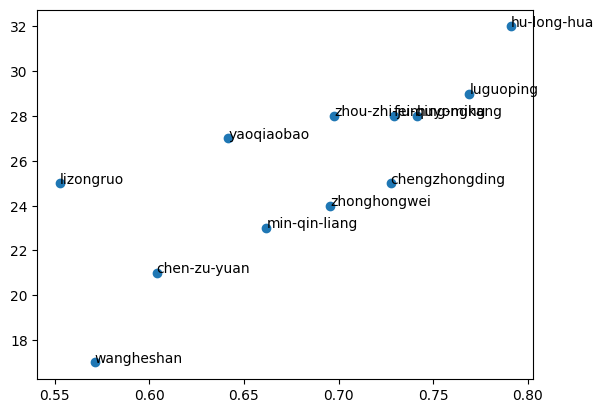

In [51]:
for beta in range(1,2):
    final_dict = {}
    for item in tqdm(file_names):
        if item != '.DS_Store':
            item = item.replace(' ','')
            final_dict[item] = pipeline(item,beta)
    x = []
    y = []
    
    mlegend = []
    test = Pinyin()
    for item in final_dict:
        x.append(final_dict[item])
        y.append(ipss[item])
        mlegend.append(item)
    plt.plot(x,y,'o')
    for i in range(len(x)):
        plt.annotate(test.get_pinyin(mlegend[i]), xy = (x[i], y[i]), xytext = (x[i], y[i]))
    plt.savefig('beta_'+str(beta)+'.png')

In [46]:
item

'wangheshan'

---

In [29]:
from scipy import spatial
def cal_DCAR(perimeter,area):
    return 4*math.pi*area/(perimeter*perimeter)
def cal_area_contour(file_name):
    img_layer = {}
    num = 64
    max_distance = 0
    # cal_num = 0
    for i in range(0, num):
        image_path = f'{path}{file_name}/' + str(i) + '.png'
        if os.path.exists(image_path):
            img_b = transfer_data(image_path)
            idx = cv2.findContours(img_b.astype(np.uint8)*255,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[0]
            cnt = idx[0]
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt,True)
            score = cal_DCAR(perimeter,area)
            
            img_layer[i] = (score,area,perimeter)
            # print(cnt)
            distance_mat = spatial.distance_matrix(cnt.reshape(-1,2),cnt.reshape(-1,2))
            if max(distance_mat.flatten()) > max_distance:
                max_distance = max(distance_mat.flatten())
            # cal_num += 1
    cal_num = max(list(img_layer.keys())) - min(list(img_layer.keys()))
    # print(max_distance)
    return img_layer,cal_num/max_distance

In [145]:
path = 'manual_after_processing/'

In [35]:
odds_dict

{'俞世忠': 3.6960001416974775,
 '颜金棋': 3.0800000733569153,
 '陈国其': 3.200204813108039,
 'chengzhongding': 3.520000060544001,
 '周志军': 3.07999998764358,
 '胡龙华': 3.0800001440412847,
 '吴兴才': 3.079999598732536,
 'wangheshan': 3.520000060544001,
 'guoanling': 3.520000060544001,
 '钟志彪': 3.2002048131080394,
 '郑瑞华': 1.9763463131131778,
 'lizongruo': 3.5200001401630496,
 '陈光时': 1.9763564482874443,
 'anxiang': 3.520000060544001,
 '刘滇康': 3.200204813108039,
 '章勤鸿': 3.07999999121799,
 '顾幼新': 3.200202679638163,
 '陆荣华': 3.0800000022801317,
 '闵勤良': 3.5420000261405438,
 '冯福金': 3.0800000078182115,
 '肖立德': 3.200204941116232,
 '金士才': 3.0800001546018567,
 '费庆明': 3.6960000373595374,
 'huyongkang': 3.520000052818322,
 'yaoqiaobao': 3.51999999504063,
 'yuzhonglin': 3.840000066048001,
 'zhonghongwei': 3.5200001393249547,
 '沈义林': 3.850000100590117,
 'luguoping': 3.5200000391725714,
 'wangzhiping': 3.5200001401630496,
 '史忠正': 3.839999982487228,
 'jinyuanlin': 2.4640000768423396,
 '殷松山': 1.976356448287445,
 '陈祖园': 3.0

In [42]:
odds_dict["陆荣华"]  = 4

In [22]:
def cal_score(img_layer,alpha=1):
    score = 0
    area_alpha_sum = 0
    average = (max(img_layer.keys()) + min(img_layer.keys()))/2
    # print(average)
    for item in img_layer:
        score += img_layer[item][0]*img_layer[item][1]**alpha
        area_alpha_sum += img_layer[item][1]**alpha
    return score/area_alpha_sum

In [229]:
file_names = os.listdir(path)

In [21]:
for ii in [-0.5]:
    final_dict = {}
    for item in tqdm(file_names):
        if item != '.DS_Store':
            item = item.replace(' ','')
            img_layer,cal_num = cal_area_contour(item)
            final_dict[item] = [cal_score(img_layer,ii),cal_num]
    x = []
    y = []
    mlegend = []
    test = Pinyin()
    for item in final_dict:
        if int(10*final_dict[item][1]*odds_dict[item]) >=0:
            x.append(final_dict[item][0])
            y.append(ipss[item])
            mlegend.append(item+'_'+str(int(100*final_dict[item][1]*odds_dict[item])))
    plt.cla()
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(x,y,'bo' ,x, poly1d_fn(x), '--k')
    for i in range(len(x)):
        plt.annotate(test.get_pinyin(mlegend[i]), xy = (x[i], y[i]), xytext = (x[i], y[i]))
    # plt.savefig('alpha_'+str(ii)+'.png')
    

  0%|          | 0/35 [00:00<?, ?it/s]


NameError: name 'cal_area_contour' is not defined

100%|██████████| 35/35 [00:29<00:00,  1.18it/s]


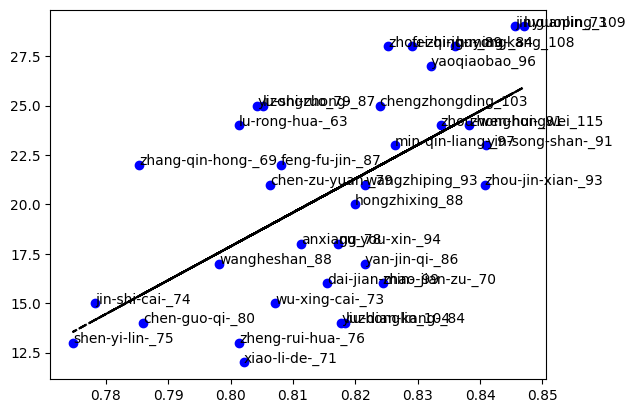

In [234]:
for ii in [0.5]:
    final_dict = {}
    for item in tqdm(file_names):
        if item != '.DS_Store':
            item = item.replace(' ','')
            img_layer,cal_num = cal_area_contour(item)
            final_dict[item] = [cal_score(img_layer,ii),cal_num]
    x = []
    y = []
    mlegend = []
    test = Pinyin()
    for item in final_dict:
        if int(10*final_dict[item][1]*odds_dict[item]) >=0:
            x.append(final_dict[item][0])
            y.append(ipss[item])
            mlegend.append(item+'_'+str(int(100*final_dict[item][1]*odds_dict[item])))
    plt.cla()
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(x,y,'bo' ,x, poly1d_fn(x), '--k')
    for i in range(len(x)):
        plt.annotate(test.get_pinyin(mlegend[i]), xy = (x[i], y[i]), xytext = (x[i], y[i]))
    # plt.savefig('alpha_'+str(ii)+'.png')
    

100%|██████████| 35/35 [00:28<00:00,  1.25it/s]


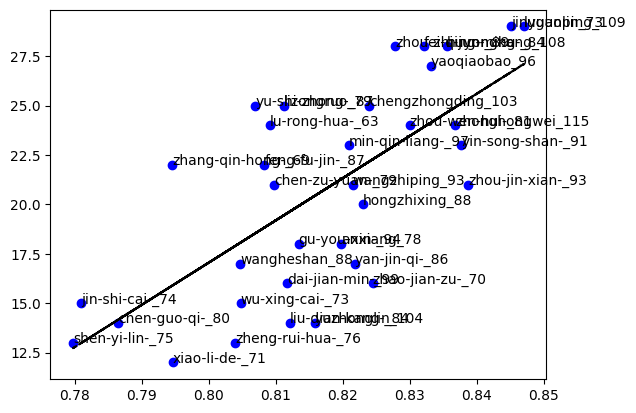

In [235]:
for ii in [0]:
    final_dict = {}
    for item in tqdm(file_names):
        if item != '.DS_Store':
            item = item.replace(' ','')
            img_layer,cal_num = cal_area_contour(item)
            final_dict[item] = [cal_score(img_layer,ii),cal_num]
    x = []
    y = []
    mlegend = []
    test = Pinyin()
    for item in final_dict:
        if int(10*final_dict[item][1]*odds_dict[item]) >=0:
            x.append(final_dict[item][0])
            y.append(ipss[item])
            mlegend.append(item+'_'+str(int(100*final_dict[item][1]*odds_dict[item])))
    plt.cla()
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(x,y,'bo' ,x, poly1d_fn(x), '--k')
    for i in range(len(x)):
        plt.annotate(test.get_pinyin(mlegend[i]), xy = (x[i], y[i]), xytext = (x[i], y[i]))
    # plt.savefig('alpha_'+str(ii)+'.png')
    

100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


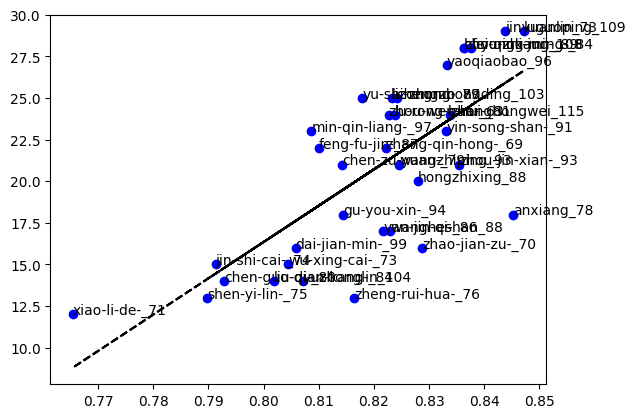

In [236]:
for ii in [-1]:
    final_dict = {}
    for item in tqdm(file_names):
        if item != '.DS_Store':
            item = item.replace(' ','')
            img_layer,cal_num = cal_area_contour(item)
            final_dict[item] = [cal_score(img_layer,ii),cal_num]
    x = []
    y = []
    mlegend = []
    test = Pinyin()
    for item in final_dict:
        if int(10*final_dict[item][1]*odds_dict[item]) >=0:
            x.append(final_dict[item][0])
            y.append(ipss[item])
            mlegend.append(item+'_'+str(int(100*final_dict[item][1]*odds_dict[item])))
    plt.cla()
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(x,y,'bo' ,x, poly1d_fn(x), '--k')
    for i in range(len(x)):
        plt.annotate(test.get_pinyin(mlegend[i]), xy = (x[i], y[i]), xytext = (x[i], y[i]))
    # plt.savefig('alpha_'+str(ii)+'.png')
    